<a href="https://colab.research.google.com/github/alechfho/timeseries-lab/blob/main/fbprophet_bike_share.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series - Why is it important

For typcial ML problems, when we make a prediction about a new observation, that model is built from hundreds or thousands of previous observations that are either all captured at a single point in time, or from data points in which time does not matter. This is known as cross-sectional data.

Time series data is different because it is recorded at regular time intervals, and the order of these data points is important. Therefore, any predictive model based on time series data will have time as an independent variable. The output of a model would be the predicted value or classification at a specific future time **based on a value or values in the past**. 

Here are a few examples of how different industries use time series forecasting: 

- Energy – Prices; demand; production schedules
- Retail – Sales; consumer demand for certain products
- State government – Sales tax receipts
- Transportation – Demand for future travel
- Finance – Stocks; market potential

However, this is the least talked about subject in most ML 

- talk about difference between additive and statistical model e.g. arima
 - curve fitting approach 
 - vs statistical approach

# Example time series


# Time series model

A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.

- Systematic: Components of the time series that have consistency or recurrence and can be described and modeled.
- Non-Systematic: Components of the time series that cannot be directly modeled.

A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series. 
- Noise: The random variation in the series.
 
Common concepts:

 - stationarity
 - irregularity
 - random walks
 

In [1]:
# !pip install numpy pandas pystan fbprophet plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet

%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

# Read in the data

Read the data in from the retail sales CSV file in the examples folder then set the index to the 'date' column. We are also parsing dates in the data file.

In [2]:
bike_share_df = pd.read_parquet('https://github.com/alechfho/timeseries-lab/raw/main/data/all_data.parquet.gzip')

# Prepare for Prophet

For prophet to work, we need to change the names of these columns to 'ds' and 'y', so lets just create a new dataframe and keep our old one handy (you'll see why later). The new dataframe will initially be created with an integer index so we can rename the columns

In [3]:
# bike_share_df.head()
# bike_share_df.rename(columns={'last_updated':'ds', 'num_bikes_available':'y'})
bike_share_df['last_updated'] = pd.to_datetime(bike_share_df['last_updated'] * 1000, unit='ms')
# bike_share_df.head(100)
bike_share_df = bike_share_df.set_index(['last_updated', 'station_id'])

bike_share_stations_df = bike_share_df.unstack()

This data is 15 minutes interval and very fine grain. Let's reduce the timescale to every hour

In [4]:
bike_share_stations_df = bike_share_stations_df.resample('1h').max()

In [5]:
bike_share_stations_df.head()

num_bikes_available                                        \
station_id                         7000  7001 7002 7003 7004  7005  7006 7007   
last_updated                                                                    
2020-10-04 20:00:00                17.0   5.0  7.0  2.0  3.0  12.0   7.0  6.0   
2020-10-04 21:00:00                17.0   7.0  5.0  1.0  4.0  12.0   9.0  5.0   
2020-10-04 22:00:00                18.0   8.0  5.0  1.0  5.0  15.0  11.0  5.0   
2020-10-04 23:00:00                20.0  10.0  5.0  3.0  5.0  16.0  11.0  5.0   
2020-10-05 00:00:00                22.0  12.0  5.0  3.0  4.0  16.0  11.0  4.0   

                                ...                                           \
station_id          7008  7009  ... 7650 7651  7653 7654 7655 7656 7657 7658   
last_updated                    ...                                            
2020-10-04 20:00:00  7.0  13.0  ...  4.0  3.0  10.0  3.0  2.0  1.0  9.0  5.0   
2020-10-04 21:00:00  7.0  14.0  ...  5.0  2.0  10.0  3.0  2.0  0.0  9.0  5.0   
2020-10-04 22:00:00  7.0  15.0  ...  5.0  2.0  10.0  3.0  2.0  0.0  9.0  5.0   
2020-10-04 23:00:00  8.0  13.0  ...  5.0  2.0   9.0  2.0  2.0  0.0  9.0  5.0   
2020-10-05 00:00:00  8.0  13.0  ...  5.0  2.0   9.0  2.0  2.0  0.0  7.0  5.0   

                               
station_id          7659 7660  
last_updated                   
2020-10-04 20:00:00  NaN  NaN  
2020-10-04 21:00:00  NaN  NaN  
2020-10-04 22:00:00  NaN  NaN  
2020-10-04 23:00:00  NaN  NaN  
2020-10-05 00:00:00  NaN  NaN  

[5 rows x 607 columns]

In [6]:
df_7030 = bike_share_stations_df['num_bikes_available']['7030'].to_frame()

In [7]:
df = bike_share_stations_df['num_bikes_available']['7030']

https://facebook.github.io/prophet/docs/quick_start.html

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

Let's rename the columns as required by fbprophet. Additioinally, fbprophet doesn't like the index to be a datetime...it wants to see 'ds' as a non-index column, so we won't set an index differnetly than the integer index.

In [8]:
df = df.reset_index()
df = df.rename(columns={'last_updated':'ds', '7030':'y'})

In [9]:
df.head(10)

,ds,y
0,2020-10-04 20:00:00,32.0
1,2020-10-04 21:00:00,31.0
2,2020-10-04 22:00:00,30.0
3,2020-10-04 23:00:00,32.0
4,2020-10-05 00:00:00,30.0
5,2020-10-05 01:00:00,28.0
6,2020-10-05 02:00:00,28.0
7,2020-10-05 03:00:00,44.0
8,2020-10-05 04:00:00,45.0
9,2020-10-05 05:00:00,45.0


Now's a good time to take a look at your data.  Plot the data using pandas' ```plot``` function

<AxesSubplot:xlabel='ds'>

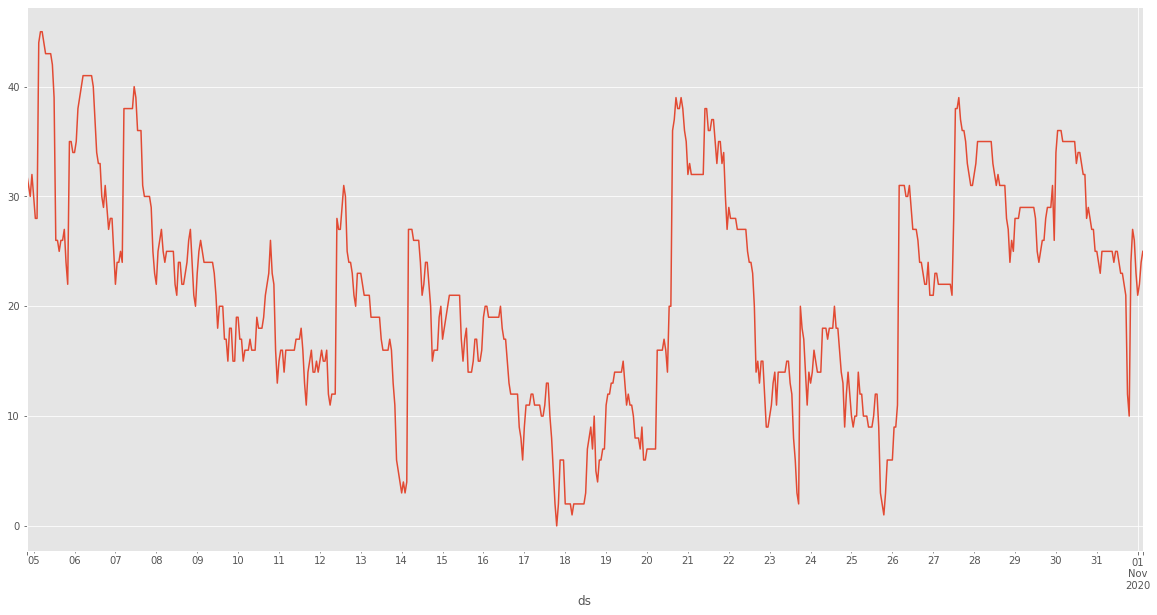

In [10]:
df.set_index('ds').y.plot()

When working with time-series data, its good to take a look at the data to determine if trends exist, whether it is stationary, has any outliers and/or any other anamolies. Facebook prophet's example uses the log-transform as a way to remove some of these anomolies but it isn't the absolute 'best' way to do this...but given that its the example and a simple data series, I'll follow their lead for now.  Taking the log of a number is easily reversible to be able to see your original data. 

To log-transform your data, you can use numpy's log() function

In this case, we don't see a trend but do see a daily cycle. One strategy is to apply a log transform:

    df['y'] = np.log(df['y'])

For timeseries data, this is referred to as seasonality.

# Running Prophet

Now, let's set prophet up to begin modeling our data.

Note: Since we are using monthly data, you'll see a message from Prophet saying ```Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.```  This is OK since we are workign with monthly data but you can disable it by using ```weekly_seasonality=True``` in the instantiation of Prophet.

In [11]:
model = Prophet(yearly_seasonality=False)
model.fit(df);

Forecasting is fairly useless unless you can look into the future, so we need to add some future dates to our dataframe. For this example, I want to forecast 2 years into the future, so I'll built a future dataframe with 24 periods since we are working with monthly data. Note the ```freq='m'``` inclusion to ensure we are adding 24 months of data.

This can be done with the following code:


In [12]:
future = model.make_future_dataframe(periods=8, freq = 'h')
future.tail()

,ds
659,2020-11-01 07:00:00
660,2020-11-01 08:00:00
661,2020-11-01 09:00:00
662,2020-11-01 10:00:00
663,2020-11-01 11:00:00


To forecast this future data, we need to run it through Prophet's model.

In [13]:
forecast = model.predict(future)

The resulting forecast dataframe contains quite a bit of data, but we really only care about a few columns.  First, let's look at the full dataframe:

In [14]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
659,2020-11-01 07:00:00,30.641568,16.613729,30.994926,30.641568,30.641568,-6.838293,-6.838293,-6.838293,1.683776,1.683776,1.683776,-8.522069,-8.522069,-8.522069,0.0,0.0,0.0,23.803276
660,2020-11-01 08:00:00,30.699004,16.714769,31.507127,30.699004,30.699004,-6.522586,-6.522586,-6.522586,1.855745,1.855745,1.855745,-8.378331,-8.378331,-8.378331,0.0,0.0,0.0,24.176418
661,2020-11-01 09:00:00,30.756440,16.776259,32.203401,30.755564,30.756440,-6.278965,-6.278965,-6.278965,1.926070,1.926070,1.926070,-8.205035,-8.205035,-8.205035,0.0,0.0,0.0,24.477475
662,2020-11-01 10:00:00,30.813876,17.069384,31.975532,30.811498,30.814073,-6.173520,-6.173520,-6.173520,1.830014,1.830014,1.830014,-8.003534,-8.003534,-8.003534,0.0,0.0,0.0,24.640356
663,2020-11-01 11:00:00,30.871312,17.252825,32.551464,30.866637,30.873959,-6.152160,-6.152160,-6.152160,1.623259,1.623259,1.623259,-7.775419,-7.775419,-7.775419,0.0,0.0,0.0,24.719152


We really only want to look at yhat, yhat_lower and yhat_upper, so we can do that with:

In [15]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
659,2020-11-01 07:00:00,23.803276,16.613729,30.994926
660,2020-11-01 08:00:00,24.176418,16.714769,31.507127
661,2020-11-01 09:00:00,24.477475,16.776259,32.203401
662,2020-11-01 10:00:00,24.640356,17.069384,31.975532
663,2020-11-01 11:00:00,24.719152,17.252825,32.551464


# Plotting Prophet results

Prophet has a plotting mechanism called ```plot```.  This plot functionality draws the original data (black dots), the model (blue line) and the error of the forecast (shaded blue area).

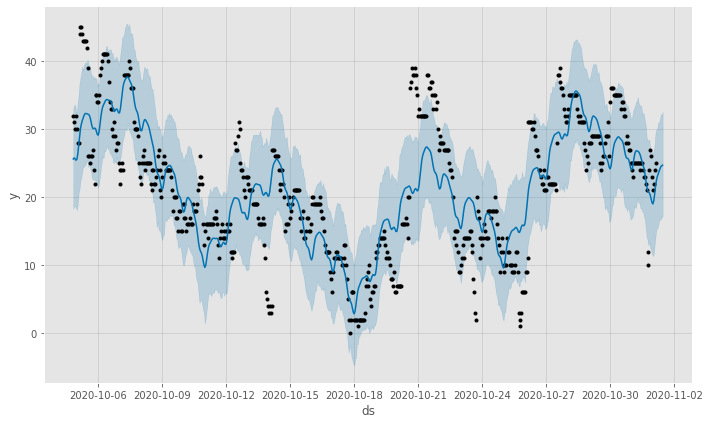

In [16]:
model.plot(forecast);

The next section describes how we can build another visualization for Prophet modeling 

# Visualizing Prophet models

In order to build a useful dataframe to visualize our model versus our original data, we need to combine the output of the Prophet model with our original data set, then we'll build a new chart manually using pandas and matplotlib.

First, let's set our dataframes to have the same index of ```ds```

In [17]:
df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)

Now, we'll combine the original data and our forecast model data

In [18]:
viz_df = df_7030.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

If we look at the ```head()```, we see the data has been joined correctly but the scales of our original data (sales) and our model (yhat) are different. We need to rescale the yhat colums(s) to get the same scale, so we'll use numpy's ```exp``` function to do that.

In [19]:
viz_df.head()

,7030,yhat,yhat_lower,yhat_upper
2020-10-04 20:00:00,32.0,25.633561,18.279654,33.016002
2020-10-04 21:00:00,31.0,25.788916,18.680798,33.478846
2020-10-04 22:00:00,30.0,25.652472,18.729954,33.618987
2020-10-04 23:00:00,32.0,25.446339,18.517479,32.688649
2020-10-05 00:00:00,30.0,25.576368,18.095881,32.503865


Let's take a look at the ```number of bikes``` and ```yhat``` data together in a chart.

<AxesSubplot:>

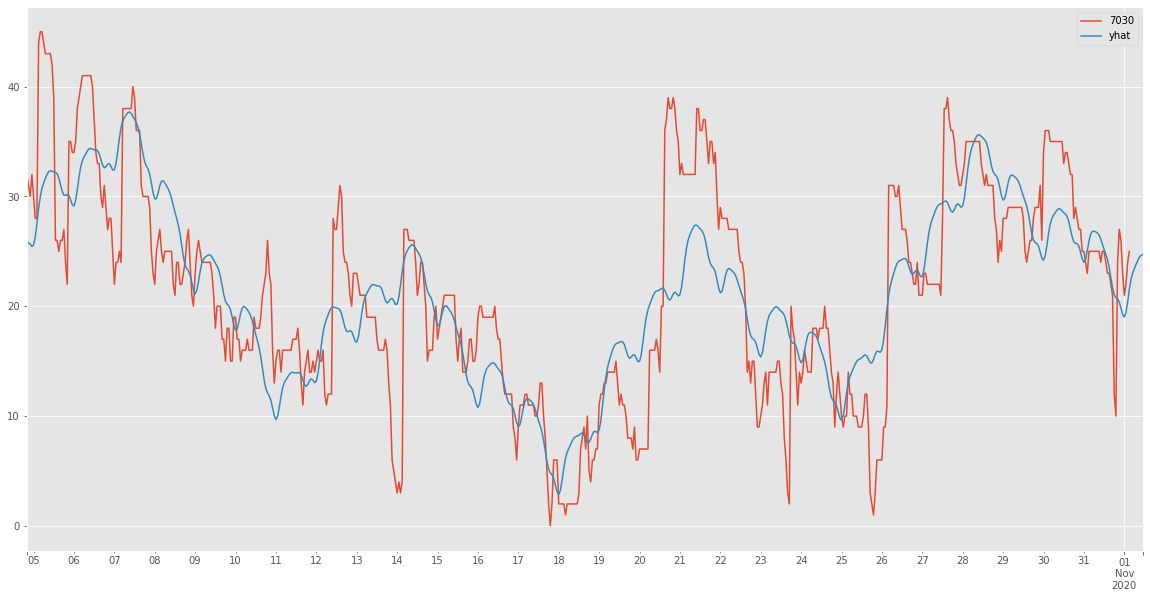

In [23]:
viz_df[['7030', 'yhat']].plot()